In [1]:
#| default_exp layers

# Functional layers

> JaX/Flax implementation of functional layers.

In [2]:
#| hide
%load_ext autoreload
%autoreload 2

In [3]:
#| export
import jax
from typing import Any, Callable, Sequence, Union
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze
from flax import linen as nn
import optax
from einops import rearrange, repeat

from fxlayers.initializers import *

## Base layer

> First we'll define a base class that will be used by every other functional layer.

In [4]:
class BaseFunctional(nn.Module):
    """Base functional layer."""
    features: int
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()
    xmean: float = 0.5
    ymean: float = 0.5

    @nn.compact
    def __call__(self,
                 inputs,
                 ):
        sigma = self.param("sigma",
                           nn.initializers.uniform(scale=1),
                           (self.features*inputs.shape[-1],))

        # x, y = jnp.meshgrid(jnp.linspace(0,1,num=self.kernel_size), jnp.linspace(0,1,num=self.kernel_size))
        # kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,None), out_axes=-1)(x, y, self.xmean, self.ymean, sigma, 1)
        # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
        kernel = self.generate_kernel()

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        return outputs

    @staticmethod
    def generate_function(x, y, xmean, ymean, sigma, A=1):
        return A*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2))

    def return_kernel(self, params):
        x, y = jnp.meshgrid(jnp.linspace(0,1,num=self.kernel_size), jnp.linspace(0,1,num=self.kernel_size))
        kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,None), out_axes=-1)(x, y, self.xmean, self.ymean, params["params"]["sigma"], 1)
        kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, 3, self.features))
        return kernel

## Gaussian layer

In [5]:
#| export
class GaussianLayer(nn.Module):
    """Parametric gaussian layer."""
    features: int
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()
    use_bias: bool = False
    xmean: float = 0.5
    ymean: float = 0.5
    fs: float = 1 # Sampling frequency
    normalize_prob: bool = True
    normalize_energy: bool = False

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 ):
        is_initialized = self.has_variable("precalc_filter", "kernel")
        precalc_filters = self.variable("precalc_filter",
                                        "kernel",
                                        jnp.zeros,
                                        (self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
        sigma = self.param("sigma",
                           nn.initializers.uniform(scale=self.xmean),
                           (self.features*inputs.shape[-1],))
        A = self.param("A",
                       nn.initializers.ones,
                       (self.features*inputs.shape[-1],))
        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (self.features,))
        else: bias = 0.

        if is_initialized and not train: 
            kernel = precalc_filters.value
        elif is_initialized and train: 
            x, y = self.generate_dominion()
            kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,0,None,None), out_axes=0)(x, y, self.xmean, self.ymean, sigma, A, self.normalize_prob, self.normalize_energy)
            # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
            kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=self.features)
            precalc_filters.value = kernel
        else:
            kernel = precalc_filters.value

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias

    @staticmethod
    def gaussian(x, y, xmean, ymean, sigma, A=1, normalize_prob=True, normalize_energy=False):
        # A_norm = 1/(2*jnp.pi*sigma) if normalize_prob else 1.
        A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*sigma**2), 1.)
        gaussian = A_norm*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2))
        E_norm = jnp.where(normalize_energy, jnp.sqrt(jnp.sum(gaussian**2)), 1.)
        return A*gaussian/E_norm

    def return_kernel(self, params, c_in):
        x, y = self.generate_dominion()
        kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,0,None,None), out_axes=0)(x, y, self.xmean, self.ymean, params["params"]["sigma"], params["params"]["A"], self.normalize_prob, self.normalize_energy)
        # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, 3, self.features))
        kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=c_in, c_out=self.features)
        return kernel
    
    def generate_dominion(self):
        return jnp.meshgrid(jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size+1)[:-1], jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size+1)[:-1])

In [6]:
#| exporti
class GaussianLayerLogSigma(nn.Module):
    """Parametric gaussian layer that optimizes log(sigma) instead of sigma."""
    features: int
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()
    use_bias: bool = False
    xmean: float = 0.5
    ymean: float = 0.5
    fs: float = 1 # Sampling frequency
    normalize_prob: bool = True
    normalize_energy: bool = False

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 ):
        is_initialized = self.has_variable("precalc_filter", "kernel")
        precalc_filters = self.variable("precalc_filter",
                                        "kernel",
                                        jnp.zeros,
                                        (self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
        logsigma = self.param("logsigma",
                           bounded_uniform(minval=-4., maxval=-0.5),
                           (self.features*inputs.shape[-1],))
        A = self.param("A",
                       nn.initializers.ones,
                       (self.features*inputs.shape[-1],))
        sigma = jnp.exp(logsigma)
        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (self.features,))
        else: bias = 0.
        if is_initialized and not train: 
            kernel = precalc_filters.value
        elif is_initialized and train: 
            x, y = self.generate_dominion()
            kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,0,None,None), out_axes=0)(x, y, self.xmean, self.ymean, sigma, A, self.normalize_prob, self.normalize_energy)
            # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
            kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=self.features)
            precalc_filters.value = kernel
        else:
            kernel = precalc_filters.value

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias

    @staticmethod
    def gaussian(x, y, xmean, ymean, sigma, A=1, normalize_prob=True, normalize_energy=False):
        # A_norm = 1/(2*jnp.pi*sigma) if normalize_prob else 1.
        A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*sigma**2), 1.)
        g = A_norm*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2))
        E_norm = jnp.where(normalize_energy, jnp.sqrt(jnp.sum(g**2)), 1.)
        return A*g/E_norm

    def return_kernel(self, params, c_in):
        x, y = self.generate_dominion()
        kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,0,None,None), out_axes=0)(x, y, self.xmean, self.ymean, jnp.exp(params["params"]["logsigma"]), params["params"]["A"], self.normalize_prob, self.normalize_energy)
        # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, 3, self.features))
        kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=c_in, c_out=self.features)
        return kernel
    
    def generate_dominion(self):
        return jnp.meshgrid(jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size+1)[:-1], jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size+1)[:-1])

In [7]:
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(28,28,3))
model = GaussianLayer(features=1, kernel_size=21, fs=21)
variables = model.init(key2, x)
state, params = variables.pop("params")
print("Parameter shapes: ", jax.tree_util.tree_map(lambda x: x.shape, params))

Parameter shapes:  FrozenDict({
    A: (3,),
    sigma: (3,),
})


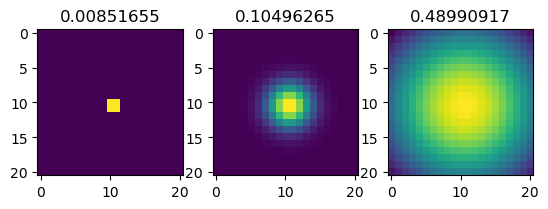

In [8]:
#| eval: false
import matplotlib.pyplot as plt
kernel = model.return_kernel({"params": params}, c_in=3)
fig, axes = plt.subplots(1, 3)
for k, sigma, ax in zip(rearrange(kernel, "kx ky cin cout -> (cin cout) kx ky"), params["sigma"], axes):
    ax.imshow(k)
    ax.set_title(sigma)
plt.show()

We can test if the precalculated filters are updated when in training mode and stay the same when in evaluation mode:

In [9]:
%%time
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=True)
assert not jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 128 ms, sys: 7.66 ms, total: 136 ms
Wall time: 235 ms


In [10]:
%%time
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=False)
assert jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 9.26 ms, sys: 975 µs, total: 10.2 ms
Wall time: 7.76 ms


We see that there is a time difference in both executions, which makes sense because when `train=False`, the filters don't have to be calculated and thus the function should run faster.

And let's see if we're able to train the layer weights while maintaining the state:

In [11]:
from functools import partial

@partial(jax.jit, static_argnums=(0, 1))
def update_step(apply_fn, tx, inputs, opt_state, params, state):
    def loss(params):
        pred, updated_state = apply_fn({"params": params, **state}, 
                                       x, 
                                       mutable=list(state.keys()), 
                                       train=True)
        loss = ((pred-inputs)**2).mean()
        return loss, updated_state
    (l, updated_state), grads = jax.value_and_grad(loss, has_aux=True)(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params, updated_state, l

In [12]:
model = GaussianLayer(features=3, kernel_size=21, fs=21)
variables = model.init(random.PRNGKey(0), x)
# Split state and params (which are updated by optimizer).
state, params = variables.pop('params')
del variables  # Delete variables to avoid wasting resources
tx = optax.sgd(learning_rate=3e-4)
opt_state = tx.init(params)

for i in range(1001):
  opt_state, params, state, loss = update_step(
      model.apply, tx, x, opt_state, params, state)
  if i % 100 == 0: print(f"Loss {i}: {loss}")

Loss 0: 11069.71875
Loss 100: 6.948000431060791
Loss 200: 4.4530110359191895
Loss 300: 3.4638028144836426
Loss 400: 2.920699119567871
Loss 500: 2.573915958404541
Loss 600: 2.3320088386535645
Loss 700: 2.153120994567871
Loss 800: 2.0152335166931152
Loss 900: 1.9056041240692139
Loss 1000: 1.8163186311721802


The loss is going down, so everything looking good so far!

## Gabor layer

> We'll repeat the process but now with a Gabor functional form.

In [13]:
#| export
class GaborLayer(nn.Module):
    """Parametric Gabor layer."""
    features: int
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()
    use_bias: bool = False
    xmean: float = 0.5
    ymean: float = 0.5
    fs: float = 1 # Sampling frequency

    normalize_prob: bool = True
    normalize_energy: bool = False

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 ):
        is_initialized = self.has_variable("precalc_filter", "kernel")
        precalc_filters = self.variable("precalc_filter",
                                        "kernel",
                                        jnp.zeros,
                                        (self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
        freq = self.param("freq",
                           nn.initializers.uniform(scale=self.fs/2),
                           (self.features*inputs.shape[-1],))
        logsigmax = self.param("logsigmax",
                           bounded_uniform(minval=-4., maxval=-0.5),
                           (self.features*inputs.shape[-1],))
        logsigmay = self.param("logsigmay",
                           bounded_uniform(minval=-4., maxval=-0.5),
                           (self.features*inputs.shape[-1],))        
        theta = self.param("theta",
                           nn.initializers.uniform(scale=jnp.pi),
                           (self.features*inputs.shape[-1],))
        sigma_theta = self.param("sigma_theta",
                           nn.initializers.uniform(scale=jnp.pi),
                           (self.features*inputs.shape[-1],))
        rot_theta = self.param("rot_theta",
                           nn.initializers.uniform(scale=jnp.pi),
                           (self.features*inputs.shape[-1],))
        A = self.param("A",
                       nn.initializers.ones,
                       (self.features*inputs.shape[-1],))
        sigmax, sigmay = jnp.exp(logsigmax), jnp.exp(logsigmay)
        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (self.features,))
        else: bias = 0.
        if is_initialized and not train: 
            kernel = precalc_filters.value
        elif is_initialized and train: 
            x, y = self.generate_dominion()
            # gabor_fn = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,0,0,0,None,None))
            kernel = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,0,0,0,0,None,None), out_axes=0)(x, y, self.xmean, self.ymean, sigmax, sigmay, freq, theta, sigma_theta, rot_theta, A, self.normalize_prob, self.normalize_energy)
            kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=self.features)
            # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
            precalc_filters.value = kernel
        else:
            kernel = precalc_filters.value

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias

    @staticmethod
    def gabor(x, y, xmean, ymean, sigmax, sigmay, freq, theta, sigma_theta, rot_theta, A=1, normalize_prob=True, normalize_energy=False):
        # ## Rotate the dominion
        # x = jnp.cos(rot_theta) * (x - xmean) - jnp.sin(rot_theta) * (y - ymean)
        # y = jnp.sin(rot_theta) * (x - xmean) + jnp.cos(rot_theta) * (y - ymean)
        x, y = x-xmean, y-ymean
        ## Obtain the normalization coeficient
        sigma_vector = jnp.array([sigmax, sigmay])
        cov_matrix = jnp.diag(sigma_vector)**2
        det_cov_matrix = jnp.linalg.det(cov_matrix)
        # A_norm = 1/(2*jnp.pi*jnp.sqrt(det_cov_matrix)) if normalize_prob else 1.
        A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*jnp.sqrt(det_cov_matrix)), 1.)
        
        ## Rotate the sinusoid
        rotation_matrix = jnp.array([[jnp.cos(sigma_theta), -jnp.sin(sigma_theta)],
                                     [jnp.sin(sigma_theta), jnp.cos(sigma_theta)]])
        rotated_covariance = rotation_matrix @ jnp.linalg.inv(cov_matrix) @ jnp.transpose(rotation_matrix)
        x_r_1 = rotated_covariance[0,0] * x + rotated_covariance[0,1] * y
        y_r_1 = rotated_covariance[1,0] * x + rotated_covariance[1,1] * y
        distance = x * x_r_1 + y * y_r_1
        g = A_norm*jnp.exp(-distance/2) * jnp.cos(2*jnp.pi*freq*(x*jnp.cos(theta)+y*jnp.sin(theta)))
        E_norm = jnp.where(normalize_energy, jnp.sqrt(jnp.sum(g**2)), 1.)
        return A*g/E_norm

    def return_kernel(self, params, c_in=3):
        x, y = self.generate_dominion()
        sigmax, sigmay = jnp.exp(params["logsigmax"]), jnp.exp(params["logsigmay"])
        # sigmax, sigmay = jnp.exp(params["sigmax"]), jnp.exp(params["sigmay"])
        kernel = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,0,0,0,0,None,None), out_axes=0)(x, y, self.xmean, self.ymean, sigmax, sigmay, params["freq"], params["theta"], params["sigma_theta"], params["rot_theta"], params["A"], self.normalize_prob, self.normalize_energy)
        # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, input_channels, self.features))
        kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=c_in, c_out=self.features)
        return kernel
    
    def generate_dominion(self):
        return jnp.meshgrid(jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size+1)[:-1], jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size+1)[:-1])

In [14]:
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(28,28,3))
model = GaborLayer(features=1, kernel_size=21, fs=21)
variables = model.init(key2, x)
state, params = variables.pop("params")
print("Parameter shapes: ", jax.tree_util.tree_map(lambda x: x.shape, params))

Parameter shapes:  FrozenDict({
    A: (3,),
    freq: (3,),
    logsigmax: (3,),
    logsigmay: (3,),
    rot_theta: (3,),
    sigma_theta: (3,),
    theta: (3,),
})


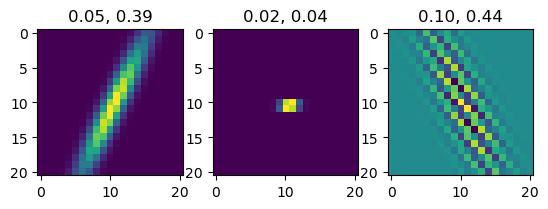

In [15]:
#| eval: false
import matplotlib.pyplot as plt
kernel = model.return_kernel(params, c_in=3)
fig, axes = plt.subplots(1, 3)
# for k, sigmax, sigmay, ax in zip(rearrange(kernel, "kx ky cin cout -> (cin cout) kx ky"), params["sigmax"], params["sigmay"], axes):
for k, sigmax, sigmay, ax in zip(rearrange(kernel, "kx ky cin cout -> (cin cout) kx ky"), jnp.exp(params["logsigmax"]), jnp.exp(params["logsigmay"]), axes):
    ax.imshow(k)
    ax.set_title(f"{sigmax:.2f}, {sigmay:.2f}")
plt.show()

We can test if the precalculated filters are updated when in training mode and stay the same when in evaluation mode:

In [16]:
%%time
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=True)
assert not jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 70.2 ms, sys: 8.96 ms, total: 79.1 ms
Wall time: 66 ms


In [17]:
%%time
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=False)
assert jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 17.9 ms, sys: 2.76 ms, total: 20.6 ms
Wall time: 18.2 ms


We see that there is a time difference in both executions, which makes sense because when `train=False`, the filters don't have to be calculated and thus the function should run faster.

And let's see if we're able to train the layer weights while maintaining the state:

In [18]:
from functools import partial

@partial(jax.jit, static_argnums=(0, 1))
def update_step(apply_fn, tx, inputs, opt_state, params, state):
    def loss(params):
        pred, updated_state = apply_fn({"params": params, **state}, 
                                       x, 
                                       mutable=list(state.keys()), 
                                       train=True)
        loss = ((pred-inputs)**2).mean()
        return loss, updated_state
    (l, updated_state), grads = jax.value_and_grad(loss, has_aux=True)(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params, updated_state, l

In [19]:
model = GaborLayer(features=1, kernel_size=21, fs=21)
variables = model.init(random.PRNGKey(0), x)
# Split state and params (which are updated by optimizer).
state, params = variables.pop('params')
params

FrozenDict({
    freq: Array([ 0.6816269, 10.3780775,  1.1226437], dtype=float32),
    logsigmax: Array([-2.4631429 , -2.717532  , -0.77407956], dtype=float32),
    logsigmay: Array([-3.0342553 , -2.29462   , -0.74401665], dtype=float32),
    theta: Array([3.050746 , 0.9813687, 1.7434841], dtype=float32),
    sigma_theta: Array([2.1122246, 2.7645009, 0.9459793], dtype=float32),
    rot_theta: Array([2.5787003, 1.4155393, 0.6662881], dtype=float32),
    A: Array([1., 1., 1.], dtype=float32),
})

In [20]:
model = GaborLayer(features=1, kernel_size=21, fs=21)
variables = model.init(random.PRNGKey(0), x)
# Split state and params (which are updated by optimizer).
state, params = variables.pop('params')
del variables  # Delete variables to avoid wasting resources
tx = optax.sgd(learning_rate=3e-4)
opt_state = tx.init(params)
print(params)

for i in range(1001):
  opt_state, params, state, loss = update_step(
      model.apply, tx, x, opt_state, params, state)
  if i % 100 == 0: print(f"Loss {i}: {loss}")
  # print(f"Loss {i}: {loss}")
  # print(params)

FrozenDict({
    freq: Array([ 0.6816269, 10.3780775,  1.1226437], dtype=float32),
    logsigmax: Array([-2.4631429 , -2.717532  , -0.77407956], dtype=float32),
    logsigmay: Array([-3.0342553 , -2.29462   , -0.74401665], dtype=float32),
    theta: Array([3.050746 , 0.9813687, 1.7434841], dtype=float32),
    sigma_theta: Array([2.1122246, 2.7645009, 0.9459793], dtype=float32),
    rot_theta: Array([2.5787003, 1.4155393, 0.6662881], dtype=float32),
    A: Array([1., 1., 1.], dtype=float32),
})
Loss 0: 11759.921875
Loss 100: 6.003412246704102
Loss 200: 3.3821327686309814
Loss 300: 2.540632724761963
Loss 400: 2.1371352672576904
Loss 500: 1.9039528369903564
Loss 600: 1.7531648874282837
Loss 700: 1.6479049921035767
Loss 800: 1.5702329874038696
Loss 900: 1.510474443435669
Loss 1000: 1.4629970788955688


The loss is going down, so everything looking good so far!

## Center Surround layer

In [21]:
#| export
class CenterSurroundLogSigma(nn.Module):
    """Parametric center surround layer that optimizes log(sigma) instead of sigma."""
    features: int
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()
    use_bias: bool = False
    xmean: float = 0.5
    ymean: float = 0.5
    fs: float = 1 # Sampling frequency
    normalize_prob: bool = True
    normalize_energy: bool = False

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 ):
        is_initialized = self.has_variable("precalc_filter", "kernel")
        precalc_filters = self.variable("precalc_filter",
                                        "kernel",
                                        jnp.zeros,
                                        (self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
        logsigma = self.param("logsigma",
                           bounded_uniform(minval=-2.2, maxval=-1.7),
                           (self.features*inputs.shape[-1],))
        logsigma2 = self.param("logsigma2",
                           bounded_uniform(minval=-2.2, maxval=-1.7),
                           (self.features*inputs.shape[-1],))
        A = self.param("A",
                       nn.initializers.ones,
                       (self.features*inputs.shape[-1],))
        sigma = jnp.exp(logsigma)
        sigma2 = jnp.exp(logsigma2)
        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (self.features,))
        else: bias = 0.
        if is_initialized and not train: 
            kernel = precalc_filters.value
        elif is_initialized and train: 
            x, y = self.generate_dominion()
            kernel = jax.vmap(self.center_surround, in_axes=(None,None,None,None,0,0,0,None,None), out_axes=0)(x, y, self.xmean, self.ymean, sigma, sigma2, A, self.normalize_prob, self.normalize_energy)
            # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
            kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=self.features)
            precalc_filters.value = kernel
        else:
            kernel = precalc_filters.value

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias

    # @staticmethod
    # def gaussian(x, y, xmean, ymean, sigma, A=1, normalize_prob=True):
    #     # A_norm = 1/(2*jnp.pi*sigma) if normalize_prob else 1.
    #     A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*sigma), 1.)
    #     return A*A_norm*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2))
    
    @staticmethod
    def center_surround(x, y, xmean, ymean, sigma, sigma2, A=1, normalize_prob=True, normalize_energy=False):
        def gaussian(x, y, xmean, ymean, sigma, A=1, normalize_prob=True):
            A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*sigma**2), 1.)
            return A*A_norm*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2))
        g1 = gaussian(x, y, xmean, ymean, sigma, 1, normalize_prob)
        g2 = gaussian(x, y, xmean, ymean, sigma2, 1, normalize_prob)
        g = g1-g2
        E_norm = jnp.where(normalize_energy, jnp.sqrt(jnp.sum(g**2)), 1.)
        return A*g/E_norm
    
    # @staticmethod
    # def center_surround(x, y, xmean, ymean, sigma,  K, A=1, normalize_prob=True):
    #     return (1/(2*jnp.pi*sigma**2))*(jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2)) - (1/(K**2))*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*(K*sigma)**2)))

    def return_kernel(self, params, c_in):
        x, y = self.generate_dominion()
        kernel = jax.vmap(self.center_surround, in_axes=(None,None,None,None,0,0,0,None,None), out_axes=0)(x, y, self.xmean, self.ymean, jnp.exp(params["params"]["logsigma"]), jnp.exp(params["params"]["logsigma2"]), params["params"]["A"], self.normalize_prob, self.normalize_energy)
        # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, 3, self.features))
        kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=c_in, c_out=self.features)
        return kernel
    
    def generate_dominion(self):
        return jnp.meshgrid(jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size+1)[:-1], jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size+1)[:-1])

In [22]:
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(28,28,3))
model = CenterSurroundLogSigma(features=1, kernel_size=21, fs=21)
variables = model.init(key2, x)
state, params = variables.pop("params")
print("Parameter shapes: ", jax.tree_util.tree_map(lambda x: x.shape, params))

Parameter shapes:  FrozenDict({
    A: (3,),
    logsigma: (3,),
    logsigma2: (3,),
})


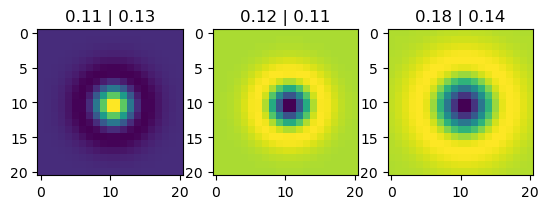

In [23]:
#| eval: false
import matplotlib.pyplot as plt
kernel = model.return_kernel({"params": params}, c_in=3)
fig, axes = plt.subplots(1, 3)
for k, sigma, sigma2, ax in zip(rearrange(kernel, "kx ky cin cout -> (cin cout) kx ky"), jnp.exp(params["logsigma"]), jnp.exp(params["logsigma2"]), axes):
    ax.imshow(k)
    ax.set_title(f"{sigma:.2f} | {sigma2:.2f}")
plt.show()

In [24]:
#| export
class CenterSurroundLogSigmaK(nn.Module):
    """Parametric center surround layer that optimizes log(sigma) instead of sigma and has a factor K instead of a second sigma."""
    features: int
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()
    use_bias: bool = False
    xmean: float = 0.5
    ymean: float = 0.5
    fs: float = 1 # Sampling frequency
    normalize_prob: bool = True
    normalize_energy: bool = True

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 ):
        is_initialized = self.has_variable("precalc_filter", "kernel")
        precalc_filters = self.variable("precalc_filter",
                                        "kernel",
                                        jnp.zeros,
                                        (self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
        logsigma = self.param("logsigma",
                           bounded_uniform(minval=-2.2, maxval=-1.7),
                           (self.features*inputs.shape[-1],))
        K = self.param("K",
                           displaced_normal(mean=1.1, stddev=0.1),
                           (self.features*inputs.shape[-1],))
        A = self.param("A",
                       nn.initializers.ones,
                       (self.features*inputs.shape[-1],))
        sigma = jnp.exp(logsigma)
        sigma2 = K*sigma
        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (self.features,))
        else: bias = 0.
        if is_initialized and not train: 
            kernel = precalc_filters.value
        elif is_initialized and train: 
            x, y = self.generate_dominion()
            kernel = jax.vmap(self.center_surround, in_axes=(None,None,None,None,0,0,0,None,None), out_axes=0)(x, y, self.xmean, self.ymean, sigma, sigma2, A, self.normalize_prob, self.normalize_energy)
            # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
            kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=self.features)
            precalc_filters.value = kernel
        else:
            kernel = precalc_filters.value

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias

    # @staticmethod
    # def gaussian(x, y, xmean, ymean, sigma, A=1, normalize_prob=True):
    #     # A_norm = 1/(2*jnp.pi*sigma) if normalize_prob else 1.
    #     A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*sigma), 1.)
    #     return A*A_norm*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2))
    
    @staticmethod
    def center_surround(x, y, xmean, ymean, sigma, sigma2, A=1, normalize_prob=True, normalize_energy=False):
        def gaussian(x, y, xmean, ymean, sigma, A=1, normalize_prob=True):
            A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*sigma**2), 1.)
            return A*A_norm*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2))
        g1 = gaussian(x, y, xmean, ymean, sigma, 1, normalize_prob)
        g2 = gaussian(x, y, xmean, ymean, sigma2, 1, normalize_prob)
        g = g1 - g2
        E_norm = jnp.where(normalize_energy, jnp.sqrt(jnp.sum(g**2)), 1.)
        return A*g/E_norm
    
    # @staticmethod
    # def center_surround(x, y, xmean, ymean, sigma,  K, A=1, normalize_prob=True):
    #     return (1/(2*jnp.pi*sigma**2))*(jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2)) - (1/(K**2))*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*(K*sigma)**2)))

    def return_kernel(self, params, c_in):
        x, y = self.generate_dominion()
        kernel = jax.vmap(self.center_surround, in_axes=(None,None,None,None,0,0,0,None,None), out_axes=0)(x, y, self.xmean, self.ymean, jnp.exp(params["params"]["logsigma"]), params["params"]["K"]*jnp.exp(params["params"]["logsigma"]), params["params"]["A"], self.normalize_prob, self.normalize_energy)
        # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, 3, self.features))
        kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=c_in, c_out=self.features)
        return kernel
    
    def generate_dominion(self):
        return jnp.meshgrid(jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size+1)[:-1], jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size+1)[:-1])

In [25]:
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(28,28,3))
model = CenterSurroundLogSigmaK(features=1, kernel_size=21, fs=21)
variables = model.init(key2, x)
state, params = variables.pop("params")
print("Parameter shapes: ", jax.tree_util.tree_map(lambda x: x.shape, params))

Parameter shapes:  FrozenDict({
    A: (3,),
    K: (3,),
    logsigma: (3,),
})


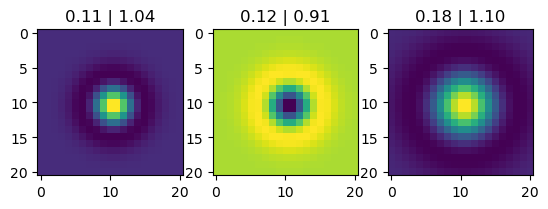

In [26]:
#| eval: false
import matplotlib.pyplot as plt
kernel = model.return_kernel({"params": params}, c_in=3)
fig, axes = plt.subplots(1, 3)
for k, sigma, K, ax in zip(rearrange(kernel, "kx ky cin cout -> (cin cout) kx ky"), jnp.exp(params["logsigma"]), params["K"], axes):
    ax.imshow(k)
    ax.set_title(f"{sigma:.2f} | {K:.2f}")
plt.show()

We can test if the precalculated filters are updated when in training mode and stay the same when in evaluation mode:

In [27]:
%%time
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=True)
assert not jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 37.7 ms, sys: 8.58 ms, total: 46.3 ms
Wall time: 36.6 ms


In [28]:
%%time
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=False)
assert jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 11 ms, sys: 1.16 ms, total: 12.2 ms
Wall time: 9.78 ms


We see that there is a time difference in both executions, which makes sense because when `train=False`, the filters don't have to be calculated and thus the function should run faster.

And let's see if we're able to train the layer weights while maintaining the state:

In [29]:
from functools import partial

@partial(jax.jit, static_argnums=(0, 1))
def update_step(apply_fn, tx, inputs, opt_state, params, state):
    def loss(params):
        pred, updated_state = apply_fn({"params": params, **state}, 
                                       x, 
                                       mutable=list(state.keys()), 
                                       train=True)
        loss = ((pred-inputs)**2).mean()
        return loss, updated_state
    (l, updated_state), grads = jax.value_and_grad(loss, has_aux=True)(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params, updated_state, l

In [30]:
model = CenterSurroundLogSigmaK(features=3, kernel_size=21, fs=21)
variables = model.init(random.PRNGKey(0), x)
# Split state and params (which are updated by optimizer).
state, params = variables.pop('params')
del variables  # Delete variables to avoid wasting resources
tx = optax.sgd(learning_rate=3e-4)
opt_state = tx.init(params)

for i in range(1001):
  opt_state, params, state, loss = update_step(
      model.apply, tx, x, opt_state, params, state)
  if i % 100 == 0: print(f"Loss {i}: {loss}")

Loss 0: 3.6809396743774414
Loss 100: 3.561089038848877
Loss 200: 3.44705867767334
Loss 300: 3.3397910594940186
Loss 400: 3.5523407459259033
Loss 500: 3.4304819107055664
Loss 600: 3.31486439704895
Loss 700: 2.956991195678711
Loss 800: 2.8722763061523438
Loss 900: 2.791658878326416
Loss 1000: 2.7149462699890137


The loss is going down, so everything looking good so far!

## Gabor_

In [31]:
#| export
class GaborLayer_(nn.Module):
    """Parametric Gabor layer with particular initialization."""
    # features: int
    n_scales: int
    n_orientations: int
    # n_phases: int
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()
    use_bias: bool = False
    xmean: float = 0.5
    ymean: float = 0.5
    fs: float = 1 # Sampling frequency
    phase = jnp.array([0., jnp.pi/2.])

    normalize_prob: bool = True
    normalize_energy: bool = False

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 ):
        features = self.n_scales * self.n_orientations * len(self.phase)
        is_initialized = self.has_variable("precalc_filter", "kernel")
        precalc_filters = self.variable("precalc_filter",
                                        "kernel",
                                        jnp.zeros,
                                        (self.kernel_size, self.kernel_size, inputs.shape[-1], features))
        freq = self.param("freq",
                           freq_scales_init(n_scales=self.n_scales, fs=self.fs),
                           (self.n_scales,))
        sigmax = self.param("sigmax",
                           k_array(k=0.4, arr=freq),
                           (self.n_scales,))
        sigmay = self.param("sigmay",
                           equal_to(1.5*sigmax),
                           (self.n_scales,))
        # theta = self.param("theta",
        #                    nn.initializers.uniform(scale=jnp.pi),
        #                    (self.n_scales*self.n_orientations,))
        theta = self.param("theta",
                           linspace(start=0, stop=jnp.pi, num=self.n_orientations),
                           (self.n_orientations,))
        sigma_theta = self.param("sigma_theta",
                           linspace(start=0, stop=jnp.pi, num=self.n_orientations),
                           (self.n_orientations,))
        # sigma_theta = theta - jnp.pi/2.
        # A = self.param("A",
        #                nn.initializers.ones,
        #                (self.features*inputs.shape[-1],))
        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (features,))
        else: bias = 0.
        if is_initialized and not train: 
            kernel = precalc_filters.value
        elif is_initialized and train: 
            x, y = self.generate_dominion()
            kernel = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,None,None,None,None,None,None), out_axes=0)
            # kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,0,None,None,None,None,None,None), out_axes=0)
            kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,None,0,0,None,None,None,None), out_axes=0)
            kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,None,None,None,0,None,None,None), out_axes=0)(x, y, self.xmean, self.ymean, sigmax, sigmay, freq, theta, sigma_theta, self.phase, 1, self.normalize_prob, self.normalize_energy)
            kernel = rearrange(kernel, "phases rots fs_sigmas kx ky -> kx ky (phases rots fs_sigmas)")
            kernel = repeat(kernel, "kx ky c_out -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=kernel.shape[-1])
            precalc_filters.value = kernel
        else:
            kernel = precalc_filters.value

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias

    @staticmethod
    def gabor(x, y, xmean, ymean, sigmax, sigmay, freq, theta, sigma_theta, phase, A=1, normalize_prob=True, normalize_energy=False):
        x, y = x-xmean, y-ymean
        ## Obtain the normalization coeficient
        sigma_vector = jnp.array([sigmax, sigmay])
        cov_matrix = jnp.diag(sigma_vector)**2
        det_cov_matrix = jnp.linalg.det(cov_matrix)
        # A_norm = 1/(2*jnp.pi*jnp.sqrt(det_cov_matrix)) if normalize_prob else 1.
        A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*jnp.sqrt(det_cov_matrix)), 1.)
        
        ## Rotate the sinusoid
        rotation_matrix = jnp.array([[jnp.cos(sigma_theta), -jnp.sin(sigma_theta)],
                                     [jnp.sin(sigma_theta), jnp.cos(sigma_theta)]])
        rotated_covariance = rotation_matrix @ jnp.linalg.inv(cov_matrix) @ jnp.transpose(rotation_matrix)
        x_r_1 = rotated_covariance[0,0] * x + rotated_covariance[0,1] * y
        y_r_1 = rotated_covariance[1,0] * x + rotated_covariance[1,1] * y
        distance = x * x_r_1 + y * y_r_1
        g = A_norm*jnp.exp(-distance/2) * jnp.cos(2*jnp.pi*freq*(x*jnp.cos(theta)+y*jnp.sin(theta)) + phase)
        E_norm = jnp.where(normalize_energy, jnp.sqrt(jnp.sum(g**2)), 1.)
        return A*g/E_norm

    def return_kernel(self, params, c_in=3):
        x, y = self.generate_dominion()
        sigmax, sigmay = jnp.exp(params["sigmax"]), jnp.exp(params["sigmay"])
        kernel = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,None,None,None,None,None,None,None), out_axes=0)
        kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,0,None,None,None,None,None,None), out_axes=0)
        kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,None,0,0,0,None,None,None), out_axes=0)(x, y, self.xmean, self.ymean, params["sigmax"], params["sigmay"], params["freq"], params["theta"], params["sigma_theta"], self.phase, 1, self.normalize_prob, self.normalize_energy)
        # kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=self.features)
        kernel = rearrange(kernel, "rots fs sigmas kx ky -> kx ky (rots fs sigmas)")
        kernel = repeat(kernel, "kx ky c_out -> kx ky c_in c_out", c_in=c_in, c_out=kernel.shape[-1])
        return kernel
    
    def generate_dominion(self):
        return jnp.meshgrid(jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size+1)[:-1], jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size+1)[:-1])

In [32]:
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(28,28,3))
model = GaborLayer_(n_scales=4, n_orientations=10, kernel_size=64, fs=64, normalize_prob=True, normalize_energy=False)
variables = model.init(key2, x)
state, params = variables.pop("params")
print("Parameter shapes: ", jax.tree_util.tree_map(lambda x: x.shape, params))

Parameter shapes:  FrozenDict({
    freq: (4,),
    sigma_theta: (10,),
    sigmax: (4,),
    sigmay: (4,),
    theta: (10,),
})


In [33]:
params

FrozenDict({
    freq: Array([24., 12.,  6.,  3.], dtype=float32),
    sigmax: Array([0.01666667, 0.03333334, 0.06666667, 0.13333334], dtype=float32),
    sigmay: Array([0.025     , 0.05      , 0.10000001, 0.20000002], dtype=float32),
    theta: Array([0.        , 0.31415927, 0.62831855, 0.9424778 , 1.2566371 ,
           1.5707964 , 1.8849556 , 2.1991148 , 2.5132742 , 2.8274336 ],      dtype=float32),
    sigma_theta: Array([0.        , 0.31415927, 0.62831855, 0.9424778 , 1.2566371 ,
           1.5707964 , 1.8849556 , 2.1991148 , 2.5132742 , 2.8274336 ],      dtype=float32),
})

In [34]:
x, y = model.generate_dominion()
kernel = jax.vmap(GaborLayer_.gabor, in_axes=(None,None,None,None,0,0,0,None,None,None,None,None,None), out_axes=0)
# kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,0,None,None,None,None,None,None), out_axes=0)
kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,None,0,0,None,None,None,None), out_axes=0)
kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,None,None,None,0,None,None,None), out_axes=0)(x, y, model.xmean, model.ymean, params["sigmax"], params["sigmay"], params["freq"], params["theta"], params["sigma_theta"], model.phase, 1, model.normalize_prob, model.normalize_energy)
# kernel = rearrange(kernel, "phases rots fs_sigmas kx ky -> kx ky (phases rots fs_sigmas)")
# kernel = repeat(kernel, "kx ky c_out -> kx ky c_in c_out", c_in=3, c_out=kernel.shape[-1])
kernel.shape

(2, 10, 4, 64, 64)

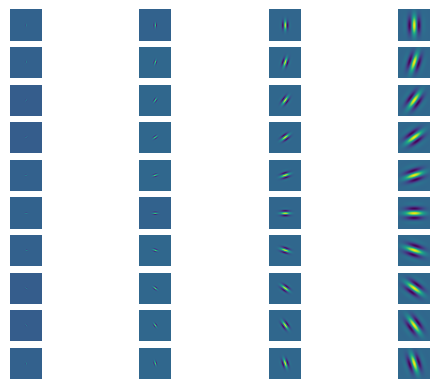

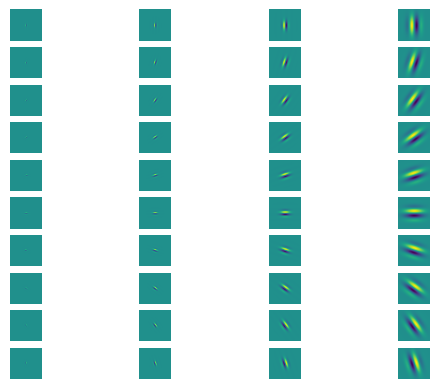

In [35]:
fig, axes = plt.subplots(kernel.shape[1],kernel.shape[2])
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(kernel[0,i,j])
        ax.axis("off")
plt.show()

fig, axes = plt.subplots(kernel.shape[1],kernel.shape[2])
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(kernel[1,i,j])
        ax.axis("off")
plt.show()

In [36]:
kernel_f = rearrange(kernel[1:2], "phases rots fs_sigmas kx ky -> (phases rots fs_sigmas) kx ky")
kernel_f.shape

(40, 64, 64)

In [37]:
kernel_f_fft = jnp.fft.fftn(kernel_f)
kernel_f_fft = jnp.fft.fftshift(kernel_f_fft)
kernel_f_fft_abs_sum = jnp.abs(kernel_f_fft).sum(axis=0)
kernel_f_fft.shape, kernel_f_fft_abs_sum.shape

((40, 64, 64), (64, 64))

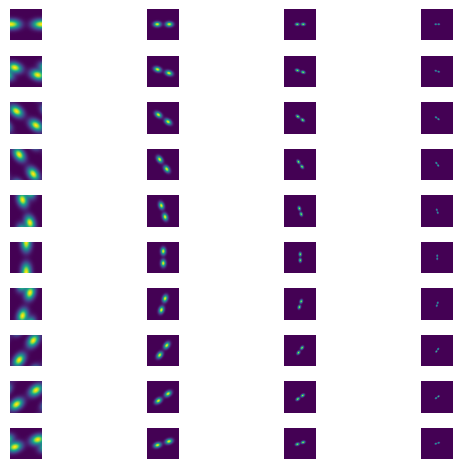

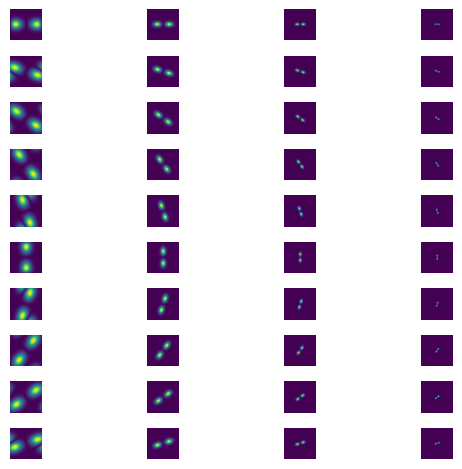

In [38]:
fig, axes = plt.subplots(kernel.shape[1],kernel.shape[2])
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(jnp.abs(jnp.fft.fftshift(jnp.fft.fftn(kernel[0,i,j]))))
        ax.axis("off")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(kernel.shape[1],kernel.shape[2])
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(jnp.abs(jnp.fft.fftshift(jnp.fft.fftn(kernel[1,i,j]))))
        ax.axis("off")
plt.tight_layout()
plt.show()

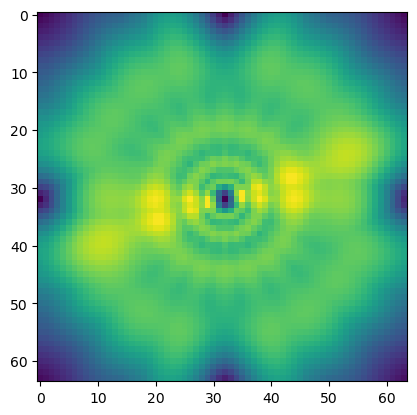

In [39]:
plt.imshow(kernel_f_fft_abs_sum)
plt.show()

In [40]:
# #| eval: false
# import matplotlib.pyplot as plt
# kernel = model.return_kernel(params, c_in=3)
# fig, axes = plt.subplots(1, 3)
# # for k, sigmax, sigmay, ax in zip(rearrange(kernel, "kx ky cin cout -> (cin cout) kx ky"), params["sigmax"], params["sigmay"], axes):
# for k, sigmax, sigmay, ax in zip(rearrange(kernel, "kx ky cin cout -> (cin cout) kx ky"), jnp.exp(params["sigmax"]), jnp.exp(params["sigmay"]), axes):
#     ax.imshow(k)
#     ax.set_title(f"{sigmax:.2f}, {sigmay:.2f}")
# plt.show()

## J & H

In [41]:
class JamesonHurvich(nn.Module):
    """Jameson & Hurvich transformation from RGB to ATD."""

    def setup(self):
        self.Mng2xyz = jnp.array([[69.1661, 52.4902, 46.6052],
                                  [39.0454, 115.8404, 16.3118],
                                  [3.3467, 12.6700, 170.1090]])
        self.Mxyz2atd = jnp.array([[0, 1, 0],
                                   [1, -1, 0],
                                   [0, 0.4, -0.4]])

    def __call__(self,
                 inputs, # (B,H,W,C)
                 **kwargs,
                 ):
        outputs = inputs**2
        outputs = inputs @ self.Mng2xyz.T @ self.Mxyz2atd.T
        return outputs

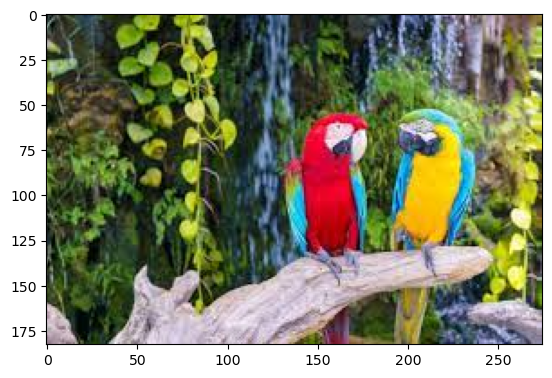

In [42]:
#| eval: false

import cv2
loros = cv2.imread("loros.jpeg")
loros = cv2.cvtColor(loros, cv2.COLOR_BGR2RGB) / 255.0
plt.imshow(loros)
plt.show()

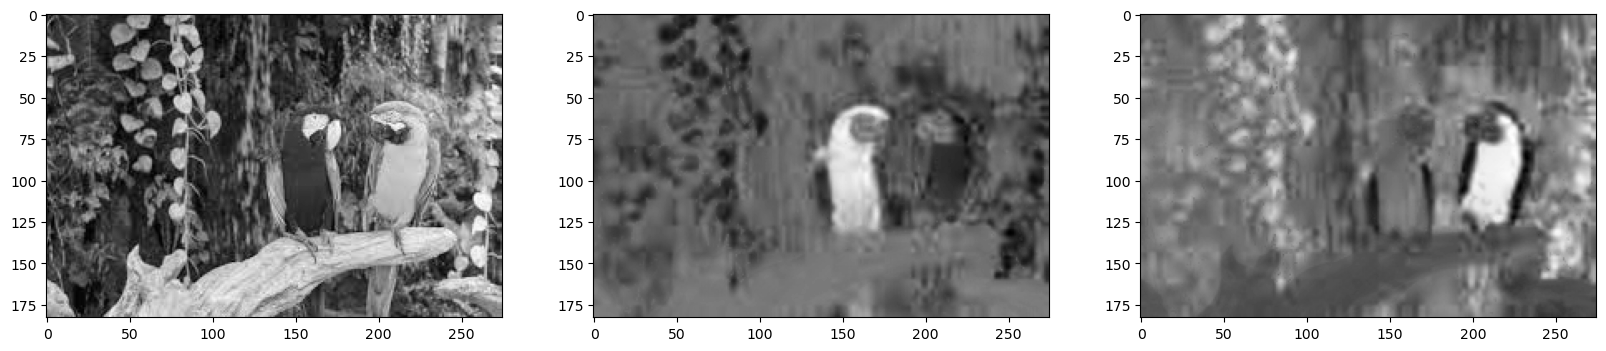

In [43]:
#| eval: false
T = JamesonHurvich()
pred = T.apply({"params":{"":[]}}, loros)
fig, axes = plt.subplots(1,3, figsize=(20,4))
for i, ax in enumerate(axes):
    ax.imshow(pred[:,:,i], cmap="gray")
plt.show()

## CSF

In [44]:
#| eval:false
from perceptualtests.utils import spatio_temp_freq_domain

In [45]:
class CSFFourier(nn.Module):
    """CSF SSO."""
    fs: int = 64
    norm_energy: bool = True

    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        alpha_achrom = self.param("alpha_achrom",
                                  equal_to(1.),
                                  (1,))
        alpha_chrom_rg = self.param("alpha_chrom_rg",
                                 equal_to(1.),
                                 (1,))
        alpha_chrom_yb = self.param("alpha_chrom_yb",
                                 equal_to(1.),
                                 (1,))
        beta_achrom = self.param("beta_achrom",
                          equal_to(1.),
                          (1,))
        beta_chrom = self.param("beta_chrom",
                          equal_to(1.),
                          (1,))
        fm = self.param("fm",
                        equal_to(7.28),
                        (1,))
        s = self.param("s",
                       equal_to(1.809),
                       (1,))
        
        b, h, w, c = inputs.shape

        ## 1. Achromatic CSF
        csf, fx, fy = self.csf_sso(fs=self.fs, Nx=w, Ny=h, alpha=alpha_achrom, beta=beta_achrom, g=330.74, fm=fm, l=0.837, s=s, w=1.0, os=6.664)

        # jax.debug.print(f"Nx={w}, Ny={h}, {csf.shape}")
        ## 2. Chromatic CSFs
        csfrg, csfyb, fx, fy = self.csf_chrom(fs=self.fs, Nx=w, Ny=h, alpha_rg=alpha_chrom_rg, alpha_yb=alpha_chrom_yb, beta=beta_chrom)
        # jax.debug.print(f"Nx={w}, Ny={h}, {csf.shape}, {csfrg.shape}, {csfyb.shape}")

        ## 3. Stack the three CSFs together
        csfs = jnp.stack([csf, csfrg, csfyb], axis=-1)

        ## 4. FFT of the input
        inputs_fft = jnp.fft.fft2(inputs, axes=(1,2))
        inputs_fft = jnp.fft.fftshift(inputs_fft)
        
        ## 5. Apply the CSF by multiplying
        E1 = jnp.sum(jnp.ones_like(csfs)**2)#**(1/2)
        E_CSF = jnp.sum(csfs**2)#**(1/2)
        if self.norm_energy: csfs = (csfs/E_CSF)*E1
        inputs_fft = csfs[None,:]*inputs_fft

        ## 6. Return to the original domain
        outputs = jnp.fft.ifft2(jnp.fft.ifftshift(inputs_fft), axes=(1,2))
        outputs = jnp.real(outputs)
        
        return outputs
    
    @staticmethod
    def csf_sso(fs, Nx, Ny, alpha, beta, g=330.74, fm=7.28, l=0.837, s=1.809, w=1.0, os=6.664):

        [_,_,_,fx,fy,_] = spatio_temp_freq_domain(Nx=Nx, Ny=Ny, Nt=1, fsx=fs, fsy=fs, fst=1)
        fx, fy = fx*beta, fy*beta
        f = jnp.sqrt(jnp.clip(fx**2 + fy**2, a_min=0.0001))
        # f = f.at[f == 0].set(0.0001)

        CSFT = g * (jnp.exp(-(f/fm)) - l*jnp.exp(-(f**2/s**2)))
        OE = 1 - w*(4*(1-jnp.exp(-(f/os)))*fx**2 *fy**2)/(f**4)
        CSFSSO = alpha*(CSFT * OE)

        return CSFSSO, fx, fy
    
    @staticmethod
    def csf_chrom(fs, Nx, Ny, alpha_rg, alpha_yb, beta):

        def sigm1d(x,x0,s):
            y = 1/(1+jnp.exp((x-x0)/s))
            return y
        
        def umbinc3(c,cu,k,m,alf,sig):
            umb = (cu-k*cu**m)*(1/(1+jnp.exp(jnp.log10(c/(alf*cu))/sig)))+(k*c**m)*(1-1/(1+jnp.exp(jnp.log10(c/(0.9*cu))/(sig/2))))
            return umb
        
        def iafrg(f, C, facfrec, nolin):
            f = facfrec*f
            f = f.at[f==0].set(0.00001)
            C = C.at[C==0].set(0.0000001)

            lf = len(f)
            lc = len(C)

            #iaf = np.zeros(lf,lc)
            ace = jnp.zeros((lf,lc))
            p = [0.0840, 0.8345, 0.6313, 0.2077]

            if len(nolin)==1:
                nolin = [nolin, nolin]

            nolini = nolin
            nolin = nolini[0]

            if ((nolini[0]==0)&(nolini[1]==1)):
                nolin=1


            if nolin==1:
                for i in range(lf):
                    cu = 1/(100*2537.9*sigm1d(f[i],-55.94,6.64))
                    ace[i,:] = umbinc3(C,cu,p[0],p[1],p[2],p[3])

                iaf = 1/ace

            else:
                iaf=100*2537.9*sigm1d(f,-55.94,6.64)
                iaf=iaf*jnp.ones((1,len(C)))

            csfrg=iaf[0,:]

            if ((nolini[0]==0)&(nolini[1]==1)):
                s = iaf.shape
                iafc = jnp.sum(iaf)
                iaf = iafc*jnp.ones((1,s[1]))

            return iaf, csfrg

        def iafyb(f, C, facfrec, nolin):
            f = facfrec*f
            f = f.at[f==0].set(0.00001)
            C = C.at[C==0].set(0.0000001)

            lf = len(f)
            lc = len(C)

            #iaf = np.zeros(lf,lc)
            ace = jnp.zeros((lf,lc))
            p = [0.1611, 1.3354, 0.3077, 0.7746]

            if len(nolin)==1:
                nolin = [nolin, nolin]

            nolini = nolin
            nolin = nolini[0]

            if ((nolini[0]==0)&(nolini[1]==1)):
                nolin=1

            if nolin==1:
                for i in range(lf):
                    cu=1/(100*719.7*sigm1d(f[i],-31.72,4.13))
                    ace[i,:]=umbinc3(C,cu,p[0],p[1],p[2],p[3])

                iaf = 1/ace

            else:
                iaf=100*719.7*sigm1d(f,-31.72,4.13)
                iaf=iaf*jnp.ones((1,len(C)))

            csfyb=iaf[0,:]

            if ((nolini[0]==0)&(nolini[1]==1)):
                s=iaf.shape
                iafc=jnp.sum(iaf)
                iaf=iafc*jnp.ones((1,s[1]))
            
            return iaf, csfyb

        [_,_,_,fx,fy,_] = spatio_temp_freq_domain(Nx=Nx, Ny=Ny, Nt=1, fsx=fs, fsy=fs, fst=1)
        fx, fy = fx*beta, fy*beta
        # f = jnp.sqrt(fx**2 + fy**2)
        f = jnp.sqrt(jnp.clip(fx**2 + fy**2, a_min=0.0001))
        #f[f == 0] = 0.0001

        csfrg = jnp.zeros((Ny,Nx))
        csfyb = jnp.zeros((Ny,Nx))

        for i in range(Ny):
            [iaf_rg, csf_c] = iafrg(f[i,:], jnp.array([0.1]), 1, jnp.array([0, 0, 0]))
            # jax.debug.print(f"{csfrg.shape} / {csf_c.shape}")
            csfrg = csfrg.at[i,:].set(csf_c)

            [iaf_yb, csf_c] = iafyb(f[i,:], jnp.array([0.1]), 1, jnp.array([0, 0, 0]))
            csfyb = csfyb.at[i,:].set(csf_c)

        fact_rg = 0.75
        fact_yb = 0.55
        max_CSF_achro = 201.3

        csfrg = fact_rg*max_CSF_achro*csfrg/jnp.max(csfrg)
        csfyb = fact_yb*max_CSF_achro*csfyb/jnp.max(csfyb)

        return alpha_rg*csfrg, alpha_yb*csfyb, fx, fy

In [46]:
model = CSFFourier()
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(1,28,29,3))
variables = model.init(key2, x)
state, params = variables.pop("params")

In [47]:
T = JamesonHurvich()
loros_atd = T.apply({"params":{"":[]}}, loros)

In [48]:
pred = model.apply({"params": params}, loros_atd[None,:])
pred.shape

(1, 183, 275, 3)

In [49]:
Mng2xyz = jnp.array([[69.1661, 52.4902, 46.6052],
                                  [39.0454, 115.8404, 16.3118],
                                  [3.3467, 12.6700, 170.1090]])
Mxyz2atd = jnp.array([[0, 1, 0],
                            [1, -1, 0],
                            [0, 0.4, -0.4]])
Mxyz2ng = jnp.linalg.inv(Mng2xyz)
Matd2xyz = jnp.linalg.inv(Mxyz2atd)

In [50]:
pred_rg = (pred @ Matd2xyz.T @ Mxyz2ng.T)**(1/2)
pred_rg.shape

(1, 183, 275, 3)

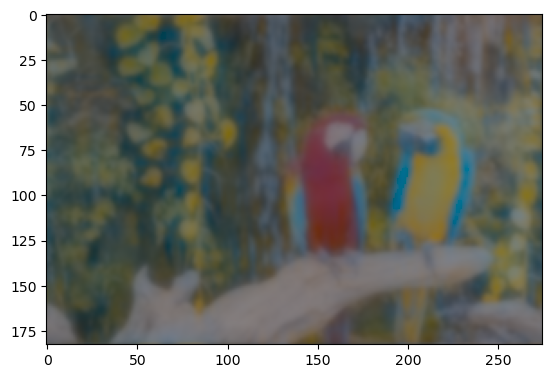

In [51]:
plt.imshow(pred_rg[0])
plt.show()

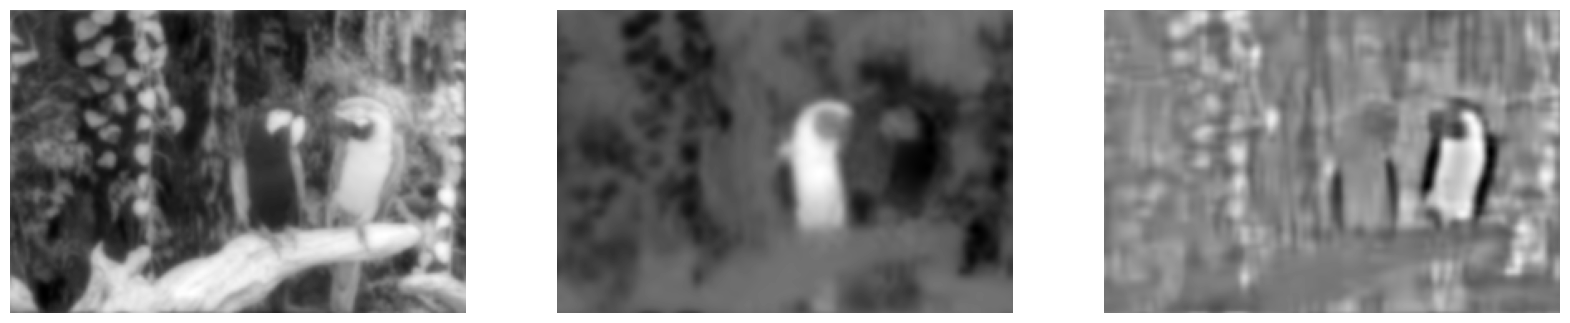

In [52]:
fig, axes = plt.subplots(1,3, figsize=(20,4))
for i in range(3):
    axes[i].imshow(pred[0][:,:,i], cmap="gray")
    axes[i].axis("off")
plt.show()

In [53]:
def step(params):
    pred = model.apply({"params": params}, loros_atd[None,:])
    return jnp.mean((pred - loros[None,:])**2)

In [54]:
lr = 3e-4
params_ = params
for it in range(N_ITERS:=1):
    loss, grad = jax.value_and_grad(step)(params_)
    params_ = jax.tree_util.tree_map(lambda p,g: p - lr*g, params_, grad)
params_

FrozenDict({
    alpha_achrom: Array(1.1451095, dtype=float32),
    alpha_chrom_rg: Array(0.950719, dtype=float32),
    alpha_chrom_yb: Array(1.010652, dtype=float32),
    beta_achrom: Array(0.8536617, dtype=float32),
    beta_chrom: Array(0.9370462, dtype=float32),
    fm: Array(7.3001676, dtype=float32),
    s: Array(1.7961693, dtype=float32),
})

In [55]:
## DN después de la CSF
# b = 0.04 [0-1]
# sigma = 0.02 (deg)

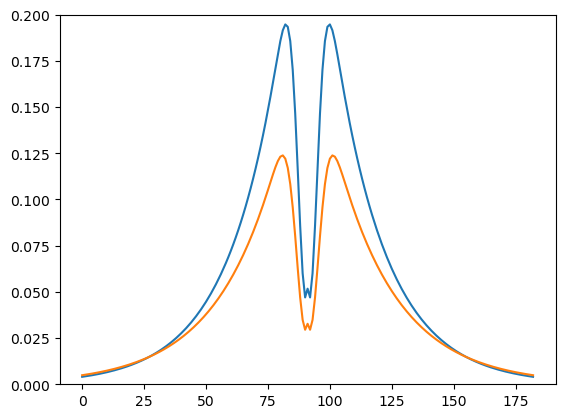

In [56]:
fs = 64
Nx, Ny = loros[None,:].shape[1:3]
alpha = 1.
beta = 1.
# for beta in [10., 1., 0.8, 0.5, 0.01, 0.]:
for p in [params, params_]:
    csf, _, _ = model.csf_sso(fs, Nx, Ny, p["alpha_achrom"], p["beta_achrom"], g=330.74, fm=p["fm"], l=0.837, s=p["s"], w=1.0, os=6.664)
    E1 = jnp.sum(jnp.ones_like(csf)**2)#**(1/2)
    E_CSF = jnp.sum(csf**2)#**(1/2)
    csf = (csf/E_CSF)*E1
    plt.plot(csf[csf.shape[0]//2], label=beta)
# plt.legend()
plt.ylim([0,0.2])
plt.show()

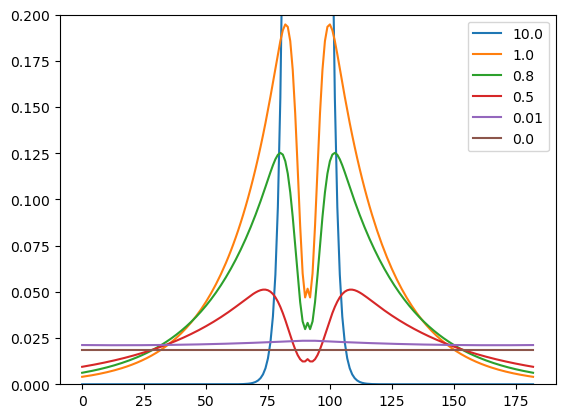

In [58]:
fs = 64
Nx, Ny = loros[None,:].shape[1:3]
alpha = 1.
beta = 1.
for beta in [10., 1., 0.8, 0.5, 0.01, 0.]:
    csf, _, _ = model.csf_sso(fs, Nx, Ny, alpha, beta, g=330.74, fm=7.28, l=0.837, s=1.809, w=1.0, os=6.664)
    E1 = jnp.sum(jnp.ones_like(csf)**2)#**(1/2)
    E_CSF = jnp.sum(csf**2)#**(1/2)
    csf = (csf/E_CSF)*E1
    plt.plot(csf[csf.shape[0]//2], label=beta)
plt.legend()
plt.ylim([0,0.2])
plt.show()

## GDN star

In [172]:
class GDNStar(nn.Module):
    """GDN variation that forces the output to be 1 when the input is x^*"""

    kernel_size: Sequence[int]
    apply_independently: bool = False
    inputs_star: float = 1.
    alpha: float = 2.
    epsilon: float = 1/2
    # kernel_init = nn.initializers.ones_init()
    # bias_init = nn.initializers.ones_init()

    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        H = nn.Conv(features=inputs.shape[-1], kernel_size=self.kernel_size, use_bias=True, feature_group_count=inputs.shape[-1] if self.apply_independently else 1)#, kernel_init=self.kernel_init, bias_init=self.bias_init)
        inputs_star = jnp.ones_like(inputs)*self.inputs_star
        denom = jnp.clip(H(inputs**self.alpha), a_min=1e-5)**self.epsilon
        coef = (jnp.clip(H(inputs_star**self.alpha), a_min=1e-5)**self.epsilon)/inputs_star
        return coef*inputs/denom

In [179]:
model = GDNStar(kernel_size=(1,1))
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(1,28,28,1))
variables = model.init(key2, x)
state, params = variables.pop("params")

In [180]:
params = unfreeze(params)
params["Conv_0"]["kernel"] *= 0.
params["Conv_0"]["kernel"] += 1.
params["Conv_0"]["bias"] += 1.
params = freeze(params)
params

FrozenDict({
    Conv_0: {
        bias: Array([1.], dtype=float32),
        kernel: Array([[[[1.]]]], dtype=float32),
    },
})

In [181]:
inputs = jnp.linspace(0, 5, num=28*28).reshape((1,28,28,1))

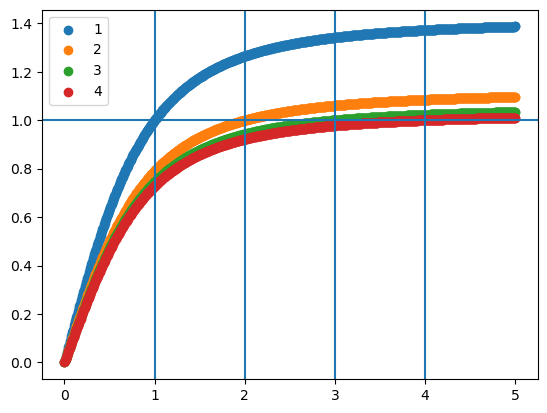

In [182]:
for inputs_star in [1, 2, 3, 4]:
    model.inputs_star = inputs_star
    pred = model.apply({"params": params}, inputs)
    plt.scatter(inputs.ravel(), pred.ravel(), label=inputs_star)
    plt.axvline(inputs_star)

plt.axhline(1)
plt.legend()
plt.show()

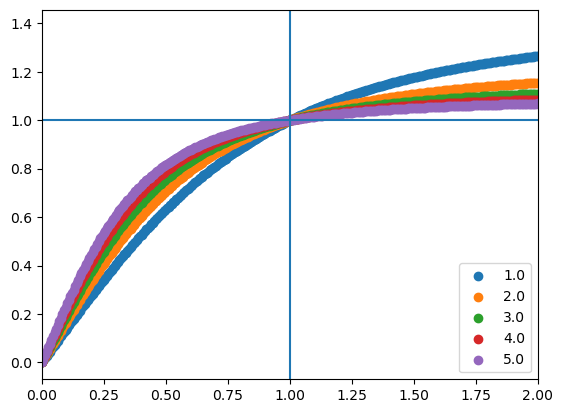

In [184]:
model.inputs_star = 1
for H in [1., 2., 3., 4., 5.]:
    params = unfreeze(params)
    params["Conv_0"]["kernel"] *= 0.
    params["Conv_0"]["kernel"] += H
    params = freeze(params)
    pred = model.apply({"params": params}, inputs)
    plt.scatter(inputs.ravel(), pred.ravel(), label=H)
plt.axhline(1)
plt.axvline(1)
plt.legend()
plt.xlim([0,2])
plt.show()

## GDN star (positives and negatives)

In [199]:
class GDNStarSign(nn.Module):
    """GDN variation that forces the output to be 1 when the input is x^*"""

    kernel_size: Sequence[int]
    apply_independently: bool = False
    inputs_star: float = 1.
    alpha: float = 2.
    epsilon: float = 1/2
    # kernel_init = nn.initializers.ones_init()
    # bias_init = nn.initializers.ones_init()

    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        inputs_sign = jnp.sign(inputs)
        inputs = jnp.abs(inputs)
        H = nn.Conv(features=inputs.shape[-1], kernel_size=self.kernel_size, use_bias=True, feature_group_count=inputs.shape[-1] if self.apply_independently else 1)#, kernel_init=self.kernel_init, bias_init=self.bias_init)
        inputs_star = jnp.ones_like(inputs)*self.inputs_star
        denom = jnp.clip(H(inputs**self.alpha), a_min=1e-5)**self.epsilon
        coef = (jnp.clip(H(inputs_star**self.alpha), a_min=1e-5)**self.epsilon)/inputs_star
        return coef*inputs*inputs_sign/denom

In [200]:
model = GDNStarSign(kernel_size=(1,1))
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(1,28,28,1))
variables = model.init(key2, x)
state, params = variables.pop("params")

In [201]:
params = unfreeze(params)
params["Conv_0"]["kernel"] *= 0.
params["Conv_0"]["kernel"] += 1.
params["Conv_0"]["bias"] += 1.
params = freeze(params)
params

FrozenDict({
    Conv_0: {
        bias: Array([1.], dtype=float32),
        kernel: Array([[[[1.]]]], dtype=float32),
    },
})

In [202]:
inputs = jnp.linspace(-5, 5, num=28*28).reshape((1,28,28,1))

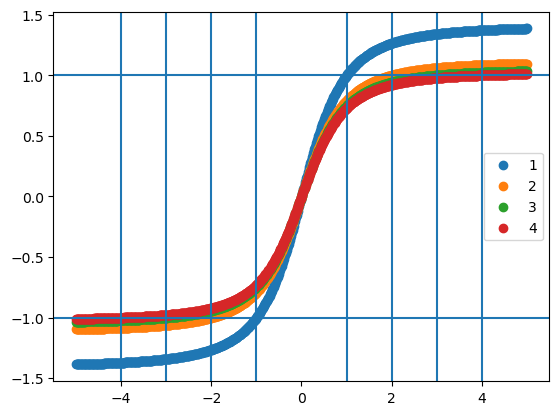

In [203]:
for inputs_star in [1, 2, 3, 4]:
    model.inputs_star = inputs_star
    pred = model.apply({"params": params}, inputs)
    plt.scatter(inputs.ravel(), pred.ravel(), label=inputs_star)
    plt.axvline(inputs_star)
    plt.axvline(-inputs_star)

plt.axhline(1)
plt.axhline(-1)
plt.legend()
plt.show()

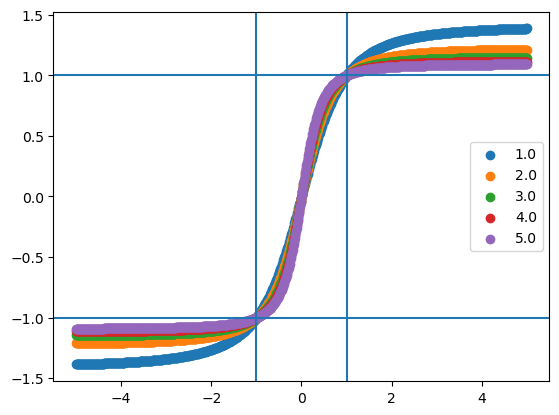

In [204]:
model.inputs_star = 1
for H in [1., 2., 3., 4., 5.]:
    params = unfreeze(params)
    params["Conv_0"]["kernel"] *= 0.
    params["Conv_0"]["kernel"] += H
    params = freeze(params)
    pred = model.apply({"params": params}, inputs)
    plt.scatter(inputs.ravel(), pred.ravel(), label=H)
plt.axhline(1)
plt.axvline(1)
plt.axhline(-1)
plt.axvline(-1)
plt.legend()
# plt.xlim([0,2])
plt.show()